## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [5]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
train, test = keras.datasets.cifar10.load_data()

In [7]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [8]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.layers import Dense, Dropout
def build_mlp(input_shape, output_units=10, num_neurons=[512, 128, 32], drop_ratio=0.3):
    """
    Build your own model
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drop_ratio)(x)
        else:
            x = Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
            x = Dropout(drop_ratio)(x)
    
    out = Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
## 超參數設定
"""
Set your hyper-parameters
"""
epochs = 50
batch_size = 256
num_neurons = {'3': [512, 128, 32], '5': [512, 256, 128, 64, 32]}
drop_ratio = [0.0, 0.3, 0.6]

In [11]:
results = {}
"""
Set your training loop
"""
for nn in num_neurons:
    for dr in drop_ratio:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print(f'num_neurons = {nn}, drop_ratio = {dr}')
        model = build_mlp(input_shape=x_train.shape[1:], num_neurons=num_neurons[nn], drop_ratio=dr)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=0.01, nesterov=True, momentum=0.9)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        name_tag = f'num_neurons = {nn}, drop_ratio = {dr}'
        results[name_tag] = {'train-loss': train_loss, 'valid-loss': valid_loss, 
                             'train-acc': train_acc, 'valid-acc': valid_acc}

num_neurons = 3, drop_ratio = 0.0
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 32)                4128      
_________________________________________________________________
dropout_3 (Dropout)      

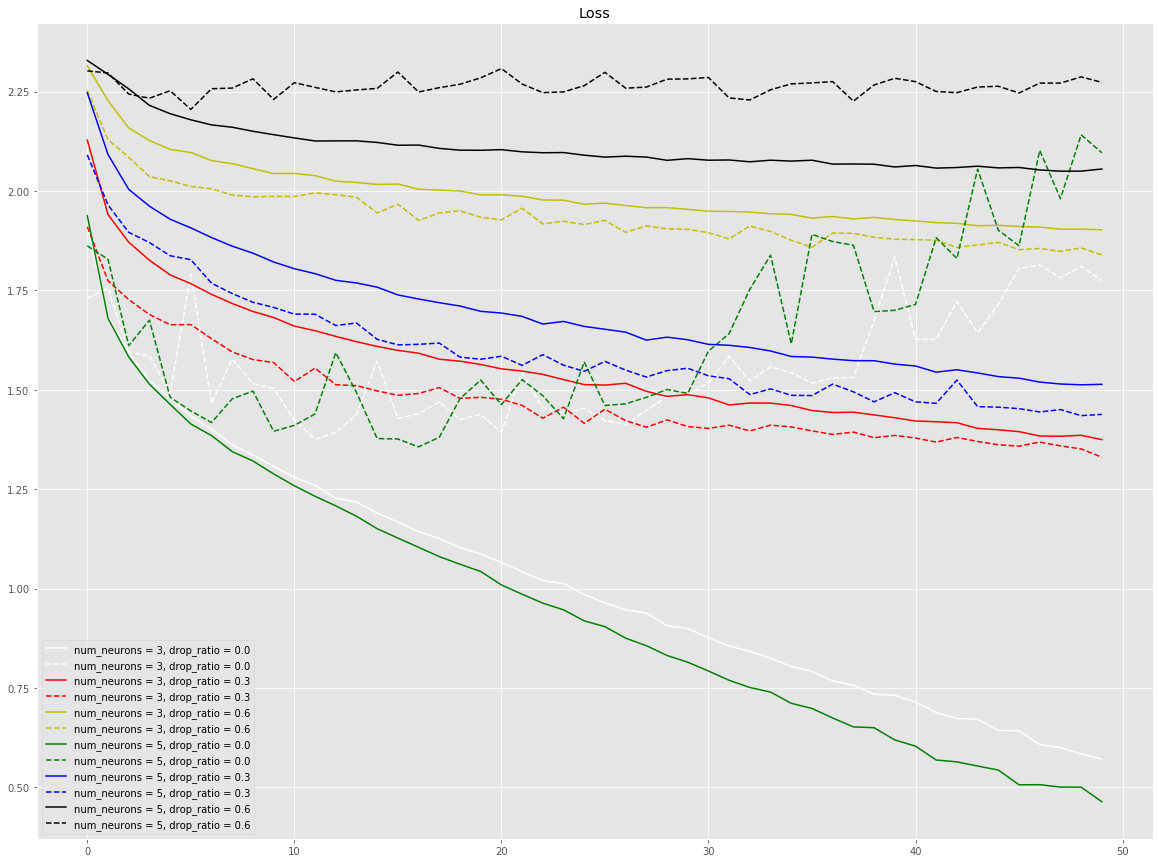

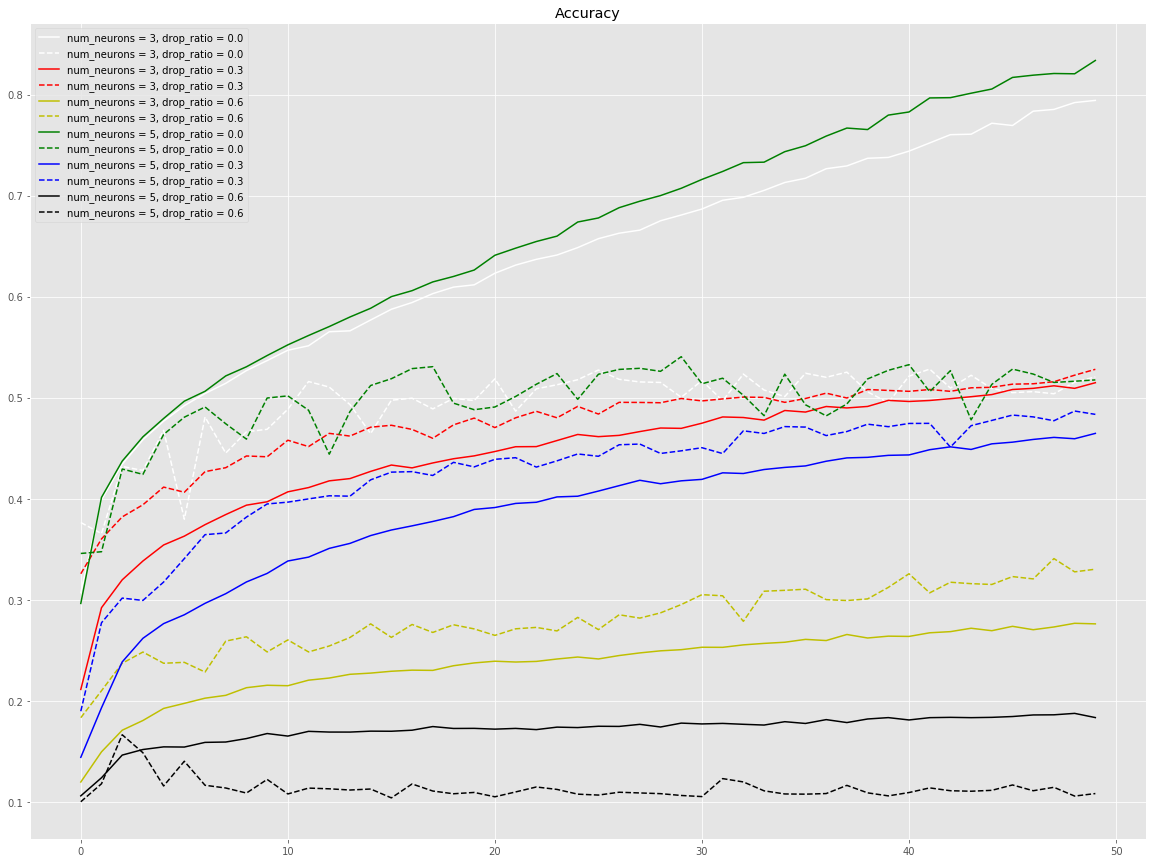

In [12]:

import matplotlib.pyplot as plt
%matplotlib inline
"""
plot the results
"""
plt.style.use('ggplot')
color_bar = ['w', 'r', 'y', 'g', 'b', 'k']

plt.figure(figsize=(20, 15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(20, 15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()